In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [5]:



# Step 1: Download AAPL data from 1990 to today
aapl_data = yf.download('AAPL', start='1990-01-01', end='2025-01-17')

# Display the first few rows to ensure the data looks good
print(aapl_data.head())





[*********************100%***********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1990-01-02  0.314732  0.334821  0.312500  0.332589   0.262129  183198400
1990-01-03  0.339286  0.339286  0.334821  0.334821   0.263889  207995200
1990-01-04  0.341518  0.345982  0.332589  0.335938   0.264769  221513600
1990-01-05  0.337054  0.341518  0.330357  0.337054   0.265649  123312000
1990-01-08  0.334821  0.339286  0.330357  0.339286   0.267408  101572800


In [6]:
import pandas_ta as ta

# Copy the dataset for feature engineering
aapl_features = aapl_data.copy()

# --- Feature Engineering ---
# 1. RSI
aapl_features['RSI'] = ta.rsi(aapl_features['Close'], length=14)

# 2. MACD
macd = ta.macd(aapl_features['Close'], fast=12, slow=26, signal=9)
aapl_features['MACD'] = macd['MACD_12_26_9']
aapl_features['MACD_Signal'] = macd['MACDs_12_26_9']
aapl_features['MACD_Hist'] = macd['MACDh_12_26_9']

# 3. Bollinger Bands
bb = ta.bbands(aapl_features['Close'], length=20, std=2)
aapl_features['BB_Upper'] = bb['BBU_20_2.0']
aapl_features['BB_Middle'] = bb['BBM_20_2.0']
aapl_features['BB_Lower'] = bb['BBL_20_2.0']

# 4. Moving Averages
aapl_features['SMA_10'] = ta.sma(aapl_features['Close'], length=10)
aapl_features['SMA_50'] = ta.sma(aapl_features['Close'], length=50)

# 5. Volume Change
aapl_features['Volume_Change'] = aapl_features['Volume'].pct_change() * 100

# 6. Lagged Features
aapl_features['RSI_Lag_1'] = aapl_features['RSI'].shift(1)
aapl_features['Close_Lag_1'] = aapl_features['Close'].shift(1)
aapl_features['RSI_Lag_2'] = aapl_features['RSI'].shift(2)
aapl_features['Close_Lag_2'] = aapl_features['Close'].shift(2)

# 7. Interaction Terms
aapl_features['RSI_Volume_Interaction'] = aapl_features['RSI'] * aapl_features['Volume_Change']
aapl_features['MACD_BB_Interaction'] = aapl_features['MACD'] * aapl_features['BB_Upper']

# --- Target Variable ---
# Daily Target: 1 if next day's close > today's close
aapl_features['Target_Daily'] = (aapl_features['Close'].shift(-1) > aapl_features['Close']).astype(int)

# Drop NaN values resulting from rolling calculations
aapl_features = aapl_features.dropna()

# Display the columns
print("Features:\n", aapl_features.columns)

# Save the dataset to a CSV file (optional)



Features:
 Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower',
       'SMA_10', 'SMA_50', 'Volume_Change', 'RSI_Lag_1', 'Close_Lag_1',
       'RSI_Lag_2', 'Close_Lag_2', 'RSI_Volume_Interaction',
       'MACD_BB_Interaction', 'Target_Daily'],
      dtype='object')


In [8]:

aapl_features.columns



Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower',
       'SMA_10', 'SMA_50', 'Volume_Change', 'RSI_Lag_1', 'Close_Lag_1',
       'RSI_Lag_2', 'Close_Lag_2', 'RSI_Volume_Interaction',
       'MACD_BB_Interaction', 'Target_Daily'],
      dtype='object')

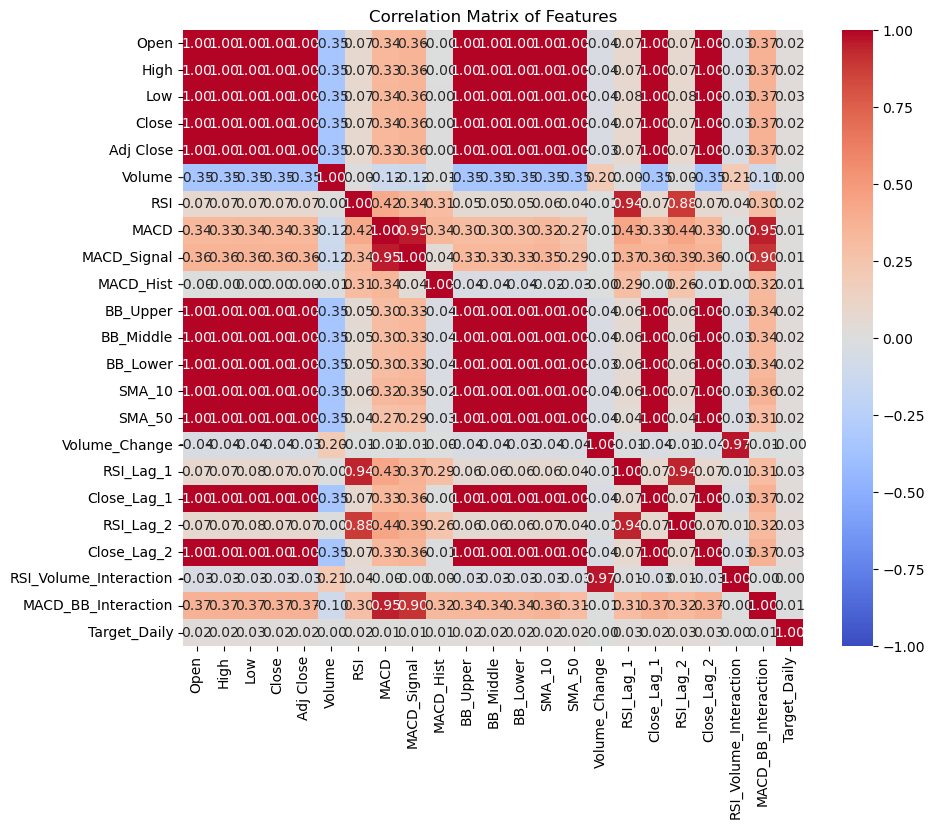

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = aapl_features.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()


In [11]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform Recursive Feature Elimination
rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(aapl_features.drop(columns=['Target_Daily']), aapl_features['Target_Daily'])

# Print selected features
selected_features = aapl_features.drop(columns=['Target_Daily']).columns[rfe.support_]
print("Selected Features:\n", selected_features)




Selected Features:
 Index(['Volume', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Lower',
       'Volume_Change', 'RSI_Lag_1', 'RSI_Lag_2', 'RSI_Volume_Interaction'],
      dtype='object')


In [16]:
# Refine the selected features to remove redundancies
refined_features = ['Volume', 'RSI', 'MACD', 'MACD_Hist', 'BB_Lower',
                    'Volume_Change', 'RSI_Lag_1', 'RSI_Lag_2', 'RSI_Volume_Interaction']

# Create a refined dataset
X_refined = aapl_features[refined_features]
y = aapl_features['Target_Daily']

print("Refined Feature Set:\n", X_refined.columns)


Refined Feature Set:
 Index(['Volume', 'RSI', 'MACD', 'MACD_Hist', 'BB_Lower', 'Volume_Change',
       'RSI_Lag_1', 'RSI_Lag_2', 'RSI_Volume_Interaction'],
      dtype='object')


Fold 1: Accuracy = 0.49
Fold 1: Total P&L = -0.76
              precision    recall  f1-score   support

           0       0.51      0.59      0.55       768
           1       0.46      0.38      0.42       695

    accuracy                           0.49      1463
   macro avg       0.48      0.48      0.48      1463
weighted avg       0.49      0.49      0.48      1463

Fold 2: Accuracy = 0.49
Fold 2: Total P&L = 0.39
              precision    recall  f1-score   support

           0       0.48      0.71      0.58       704
           1       0.52      0.29      0.37       759

    accuracy                           0.49      1463
   macro avg       0.50      0.50      0.47      1463
weighted avg       0.50      0.49      0.47      1463

Fold 3: Accuracy = 0.52
Fold 3: Total P&L = 12.52
              precision    recall  f1-score   support

           0       0.49      0.59      0.53       690
           1       0.55      0.45      0.50       773

    accuracy                     

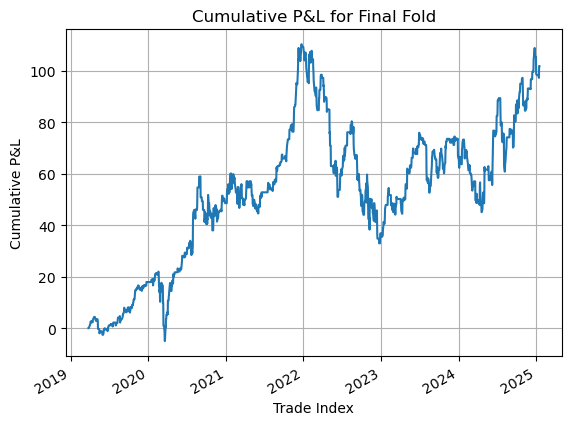

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the number of splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight= None, max_depth = None, max_features= "sqrt", min_samples_leaf= 4, min_samples_split= 10, n_estimators= 150)

# Perform cross-validation
fold_accuracies = []
fold_pnls = []  # To store total P&L for each fold

# Add a shifted Close column for Next_Close
aapl_features['Next_Close'] = aapl_features['Close'].shift(-1)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_refined)):
    # Split the data
    X_train, X_val = X_refined.iloc[train_idx], X_refined.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Validate the model
    y_pred = rf_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    fold_accuracies.append(accuracy)
    
    # P&L Calculation
    # Validation data with Close and Next_Close for P&L calculations
    val_data = X_val.copy()
    val_data['y_true'] = y_val
    val_data['y_pred'] = y_pred
    val_data['Close'] = aapl_features['Close'].iloc[val_idx].values
    val_data['Next_Close'] = aapl_features['Next_Close'].iloc[val_idx].values
    val_data['P&L'] = (val_data['Next_Close'] - val_data['Close']) * val_data['y_pred']
    
    # Calculate total P&L for this fold
    total_pnl = val_data['P&L'].sum()
    fold_pnls.append(total_pnl)
    
    print(f"Fold {fold + 1}: Accuracy = {accuracy:.2f}")
    print(f"Fold {fold + 1}: Total P&L = {total_pnl:.2f}")
    print(classification_report(y_val, y_pred, zero_division=0))

# Overall cross-validation performance
mean_accuracy = sum(fold_accuracies) / n_splits
mean_pnl = sum(fold_pnls) / n_splits

print(f"\nMean Accuracy: {mean_accuracy:.2f}")
print(f"Mean P&L: {mean_pnl:.2f}")

# Plot cumulative P&L for the final fold as an example
val_data['Cumulative_P&L'] = val_data['P&L'].cumsum()
val_data['Cumulative_P&L'].plot(title='Cumulative P&L for Final Fold')
plt.xlabel('Trade Index')
plt.ylabel('Cumulative P&L')
plt.grid(True)
plt.show()


In [21]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

# Initialize Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',  # You can change this to 'precision', 'recall', or 'f1'
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_refined, y)

# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model
best_rf_model = grid_search.best_estimator_0


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Hyperparameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


Feature Importances:
                  Feature  Importance
0                  Volume    0.115642
1                     RSI    0.114516
7               RSI_Lag_2    0.114054
3               MACD_Hist    0.113134
2                    MACD    0.112995
4                BB_Lower    0.112748
6               RSI_Lag_1    0.111381
8  RSI_Volume_Interaction    0.104434
5           Volume_Change    0.101097


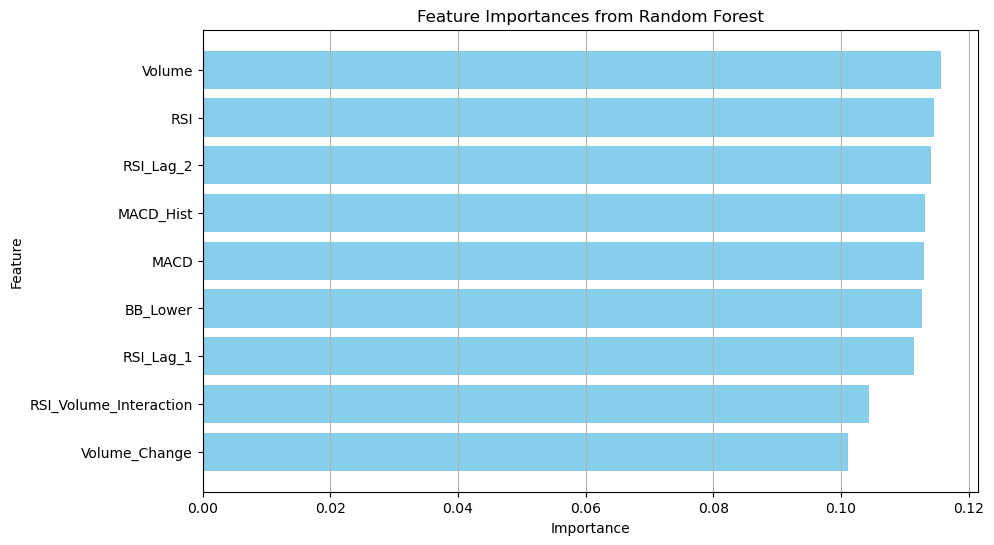

In [27]:
# Extract feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': X_refined.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print("Feature Importances:")
print(importances_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.grid(axis='x')
plt.show()
